<a href="https://colab.research.google.com/github/anargh-t/Graph-RAG/blob/main/GraphRAG_using_Llama_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain-experimental langchain-community langchain langchain-core langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00


In [3]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
import time
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
import json

from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

In [4]:
llm = ChatGroq(temperature=0, model_name='llama-3.1-8b-instant', groq_api_key='')

In [5]:
text = """Shalini Shukla, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity. She was the first woman to win the ABC Award, the first person to win the ABC Award twice, and the only person to win the ABC Award in two scientific fields.
Her husband, Ravi Pandey, was a co-winner of her first ABC Award, making them the first-ever married couple to win the ABC Award and launching the Shukla family legacy of five ABC Awards.
In 1906, she became the first woman to become a professor at the University of Paris."""

documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(llm=llm)

In [6]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,

)

graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)


In [7]:
graph = NetworkxEntityGraph()

#Add nodes to the graph
for node in graph_documents_filtered[0].nodes:
    graph.add_node(node.id)

#Add edges to the graph
for edge in graph_documents_filtered[0].relationships:
    graph._graph.add_edge(
        edge.source.id,
        edge.target.id,
        relation=edge.type,
    )

In [8]:
graph_rag = GraphQAChain.from_llm(
    llm = llm,
    graph = graph,
    verbose = True
)

In [9]:
import pandas as pd
df = pd.DataFrame(columns=['node1','node2','relation'])

for edge in graph_documents_filtered[0].relationships:
    df = pd.concat([df,pd.DataFrame({'node1':[edge.source.id], 'node2':[edge.target.id], 'relation':[edge.type]})], ignore_index=True)
df

,node1,node2,relation
0,Shalini Shukla,University Of Paris,PROFESSOR
1,Shalini Shukla,Ravi Pandey,MARRIED_TO


In [11]:
question = """who is shalini shukla"""
graph_rag.run(question)

/tmp/ipython-input-3110712762.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  graph_rag.run(question)




> Entering new GraphQAChain chain...
Entities Extracted:
Shalini Shukla
Full Context:
Shalini Shukla PROFESSOR University Of Paris
Shalini Shukla MARRIED_TO Ravi Pandey

> Finished chain.


'Based on the given knowledge triplets, I can tell you that Shalini Shukla is a professor at the University of Paris and is married to Ravi Pandey.'

{('Shalini Shukla',
  'University Of Paris'): Text(0.4999902570122017, 0.24628337880514894, 'PROFESSOR'),
 ('Shalini Shukla',
  'Ravi Pandey'): Text(-0.49999882578800003, -0.2462716600273962, 'MARRIED_TO')}

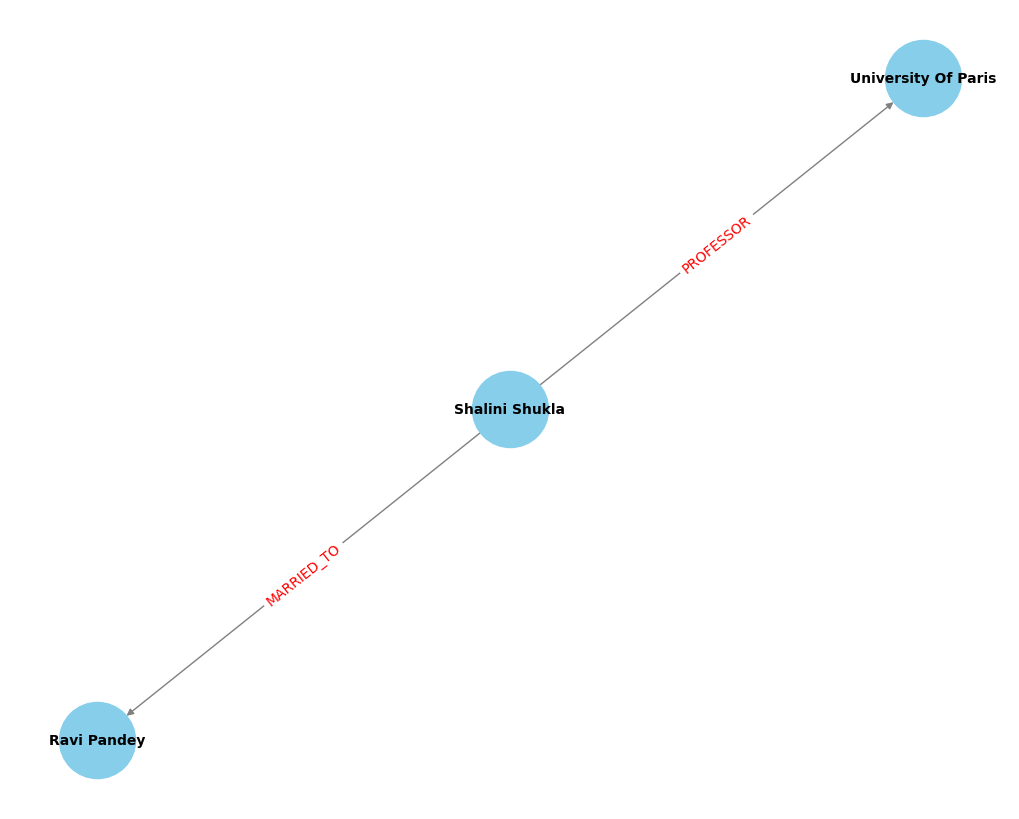

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in df.iterrows():
    G.add_edge(row['node1'], row['node2'], relationship=row['relation'])

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'relationship')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')